In [1]:
from preprocessing import get_model_dataset, create_train_test, min_max_scale, df_to_xy, read_file, lag_features, read_files
from lstm import create_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

In [2]:
# Processed data
first_year = 2019
last_year = 2021
file = f"./data/processed_data/{first_year}-{last_year}.csv"
df_read = read_file(file)

In [3]:
# Raw data for 2021
path_opt = "./data/options/"
filenames_opt = ["spx_eod_" + str(year) + (str(month) if month >= 10 else "0" + str(month)) + ".txt" for year in range(2021, 2022) for month in range(1, 13)]
#filenames_opt = ["spx_eod_202209.txt"]

df_2021 = read_files(path_opt, filenames_opt)

In [4]:
#Row with highest ask bid spread
df_2021_clean = df_2021[df_2021['[C_BID]'] != 0]
max_row = pd.Series(df_2021_clean['[C_ASK]']-df_2021_clean['[C_BID]']).argmax()
max_spread = df_2021_clean.iloc[max_row]["[C_ASK]"]-df_2021_clean.iloc[1946623]["[C_BID]"]
print("Max row ", max_row, " has a spread of ", max_spread, "with a ask of ", df_2021_clean.iloc[max_row]["[C_ASK]"], "and bid of ", df_2021_clean.iloc[max_row]["[C_BID]"])

Max row  1946623  has a spread of  1415.7999999999997 with a ask of  5059.9 and bid of  3644.1


In [5]:
print("---Info----")
df_read.info()

---Info----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5123798 entries, 0 to 5123797
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Quote_date       object 
 2   Expire_date      object 
 3   Underlying_last  float64
 4   Strike           float64
 5   Ask              float64
 6   Bid              float64
 7   Bid_strike       float64
 8   Ask_strike       float64
 9   Moneyness        float64
 10  Ttl              int64  
 11  Volatility       float64
 12  R                float64
dtypes: float64(9), int64(2), object(2)
memory usage: 508.2+ MB


In [6]:
# Max Time to live
print("Longest time to live: ", df_read["Ttl"].max())

Longest time to live:  1095


In [7]:
tests = [10000, 1586, 1089, 365*2, 365, 180, 90, 60, 30, 15, 0]
x = []
y = []
for test in tests:
    print('Count Ttl >', test, ':', df_read["Ttl"][df_read['Ttl'] > test].count())
    x.append(test)
    y.append(df_read["Ttl"][df_read['Ttl'] > test].count())


Count Ttl > 10000 : 0
Count Ttl > 1586 : 0
Count Ttl > 1089 : 408
Count Ttl > 730 : 88853
Count Ttl > 365 : 362735
Count Ttl > 180 : 900201
Count Ttl > 90 : 1834026
Count Ttl > 60 : 2260711
Count Ttl > 30 : 3123010
Count Ttl > 15 : 4037921
Count Ttl > 0 : 5123798


Text(0, 0.5, 'Number of data points')

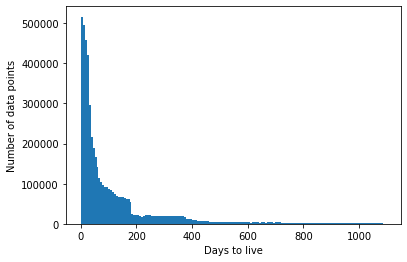

In [8]:
# Ttl distribution
ax = df_read["Ttl"].plot.hist(bins=157)
ax.set_xlabel("Days to live")
ax.set_ylabel("Number of data points")

Text(0, 0.5, 'Number of data points')

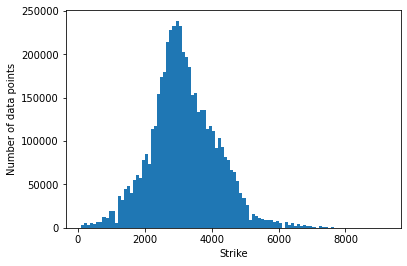

In [9]:
# Strike distribution
ax = df_read["Strike"].plot.hist(bins=100)
ax.set_xlabel("Strike")
ax.set_ylabel("Number of data points")

Text(0, 0.5, 'Number of data points')

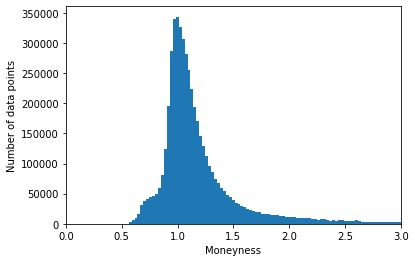

In [10]:
# Moneyness distribution
ax = df_read["Moneyness"].plot.hist(bins=1800)
ax.set_xlabel("Moneyness")
ax.set_xlim(0,3)
ax.set_ylabel("Number of data points")

In [11]:
tests = [50, 25, 10, 5, 2, 1.5, 1.03, 1, 0.97, 0.5, 0]
print(df_read["Moneyness"].max())
print(df_read["Moneyness"].min())
for test in tests:
    print('Moneyness Ttl >', test, ':', df_read["Moneyness"][df_read['Moneyness'] > test].count() / df_read["Moneyness"].count() * 100)

47.9294
0.4562775510204082
Moneyness Ttl > 50 : 0.0
Moneyness Ttl > 25 : 0.07223157509331946
Moneyness Ttl > 10 : 0.28633056962823283
Moneyness Ttl > 5 : 0.6770368386888007
Moneyness Ttl > 2 : 6.3422094313632185
Moneyness Ttl > 1.5 : 13.902499669190707
Moneyness Ttl > 1.03 : 61.69587481785972
Moneyness Ttl > 1 : 69.07145832056611
Moneyness Ttl > 0.97 : 76.7483417574229
Moneyness Ttl > 0.5 : 99.99865334269617
Moneyness Ttl > 0 : 100.0


In [12]:
print(df_read["Strike"][df_read["Ttl"] <= 3*365].max())
print(df_read["Strike"].min())
tester = "Strike"
tests = [8600, 7600, 6600, 5600, 4600, 3600, 2600, 1600, 600, 100, 0]
for test in tests:
    print(tester, '>', test, ':', df_read[tester][df_read[tester] > test].count() / df_read[tester].count() * 100)

9200.0
100.0
Strike > 8600 : 0.00046840254045924526
Strike > 7600 : 0.0021858785221431443
Strike > 6600 : 0.2711270038358265
Strike > 5600 : 1.4702765409565326
Strike > 4600 : 7.6027001845115665
Strike > 3600 : 30.2223467826015
Strike > 2600 : 73.19896295677543
Strike > 1600 : 94.19842468418935
Strike > 600 : 99.42501636481376
Strike > 100 : 99.92644128437537
Strike > 0 : 100.0


In [13]:
df_read[(df_read["Strike"] == 9200)]

,Unnamed: 0,Quote_date,Expire_date,Underlying_last,Strike,Ask,Bid,Bid_strike,Ask_strike,Moneyness,Ttl,Volatility,R
5058345,6456540,2021-12-21,2024-12-20,4648.98,9200.0,19.7,0.5,0.000054,0.002141,0.505324,1095,0.135275,0.96
5067505,6465700,2021-12-22,2024-12-20,4696.40,9200.0,300.0,0.0,0.000000,0.032609,0.510478,1094,0.136229,0.96
5076778,6474973,2021-12-23,2024-12-20,4725.38,9200.0,19.2,0.0,0.000000,0.002087,0.513628,1093,0.136510,0.97
5085894,6484089,2021-12-27,2024-12-20,4791.49,9200.0,19.2,0.0,0.000000,0.002087,0.520814,1089,0.138249,0.98
5095447,6493642,2021-12-28,2024-12-20,4787.26,9200.0,12.7,3.5,0.000380,0.001380,0.520354,1088,0.138268,0.99
5104935,6503130,2021-12-29,2024-12-20,4792.94,9200.0,19.2,0.0,0.000000,0.002087,0.520972,1087,0.138236,0.99
5114469,6512664,2021-12-30,2024-12-20,4779.28,9200.0,19.2,0.0,0.000000,0.002087,0.519487,1086,0.137746,0.98
5123797,6521992,2021-12-31,2024-12-20,4766.39,9200.0,300.0,0.0,0.000000,0.032609,0.518086,1085,0.136456,0.97


In [14]:
df_read[df_read["Quote_date"] <= "2021-12-31"].max()

Unnamed: 0            6521992
Quote_date         2021-12-31
Expire_date        2024-12-20
Underlying_last       4792.94
Strike                   9200
Ask                    4693.5
Bid                    4624.9
Bid_strike             46.249
Ask_strike             46.745
Moneyness             47.9294
Ttl                      1095
Volatility           0.543244
R                        2.62
dtype: object

In [15]:
df_read[(df_read["Strike"] == 9200)]

,Unnamed: 0,Quote_date,Expire_date,Underlying_last,Strike,Ask,Bid,Bid_strike,Ask_strike,Moneyness,Ttl,Volatility,R
5058345,6456540,2021-12-21,2024-12-20,4648.98,9200.0,19.7,0.5,0.000054,0.002141,0.505324,1095,0.135275,0.96
5067505,6465700,2021-12-22,2024-12-20,4696.40,9200.0,300.0,0.0,0.000000,0.032609,0.510478,1094,0.136229,0.96
5076778,6474973,2021-12-23,2024-12-20,4725.38,9200.0,19.2,0.0,0.000000,0.002087,0.513628,1093,0.136510,0.97
5085894,6484089,2021-12-27,2024-12-20,4791.49,9200.0,19.2,0.0,0.000000,0.002087,0.520814,1089,0.138249,0.98
5095447,6493642,2021-12-28,2024-12-20,4787.26,9200.0,12.7,3.5,0.000380,0.001380,0.520354,1088,0.138268,0.99
5104935,6503130,2021-12-29,2024-12-20,4792.94,9200.0,19.2,0.0,0.000000,0.002087,0.520972,1087,0.138236,0.99
5114469,6512664,2021-12-30,2024-12-20,4779.28,9200.0,19.2,0.0,0.000000,0.002087,0.519487,1086,0.137746,0.98
5123797,6521992,2021-12-31,2024-12-20,4766.39,9200.0,300.0,0.0,0.000000,0.032609,0.518086,1085,0.136456,0.97


<font size="5">Statistics table</font>

In [16]:
# Drop ID
df_read = df_read.drop(["Unnamed: 0"], axis = 1)

In [17]:
# Making date to date format to be able to group by year
df_read['Quote_date'] = pd.to_datetime(df_read.Quote_date, format='%Y-%m-%d')
df2 = df_read.groupby(df_read.Quote_date.dt.year)

In [18]:
summary = df2.describe().round(decimals=2).transpose().astype(str)

In [19]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):

    print(summary)

Quote_date                  2019       2020       2021
Underlying_last count  1412347.0  1685464.0  2025987.0
                mean     2916.58    3203.46    4290.48
                std       155.46     329.58      286.0
                min      2446.85    2235.76    3701.38
                25%      2822.43    3002.74    4111.97
                50%      2923.48    3273.64    4343.44
                75%      3005.61    3400.95     4511.6
                max      3240.07    3756.31    4792.94
Strike          count  1412347.0  1685464.0  2025987.0
                mean      2597.2     2887.3    3805.08
                std       558.36     772.43    1059.77
                min        100.0      100.0      100.0
                25%       2310.0     2475.0     3300.0
                50%       2685.0     2975.0     3920.0
                75%       2970.0     3370.0     4425.0
                max       4800.0     6500.0     9200.0
Ask             count  1412347.0  1685464.0  2025987.0
          

In [20]:
with open('mytable.tex', 'w') as tf:
     tf.write(summary.to_latex())